https://machinelearningmastery.com/xgboost-for-time-series-forecasting/?__cf_chl_tk=Ys_GJWx4Z.qSLLyF84OVv7O5HwEHC77TOzgb_9zsuPo-1742236350-1.0.1.1-eH9oFZyZ8iX0lWeKJfn_cKnIxxWQhnQMuQ7jYe5wTxU

In [1]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


nu al train split maken 

In [61]:
import pandas as pd

# 1. Dataset inladen
df = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets_time_index.csv",)



# 3. Stel hoeveel maanden voor validatie en test
n_val = 12   # voorlaatste jaar
n_test = 12  # laatste jaar

# 4. Bereken splits
n_total = len(df)
n_train = n_total - n_val - n_test

# 5. Maak splits
df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train + n_val].copy()
df_test  = df.iloc[n_train + n_val:].copy()

# 6. Opslaan als aparte CSV-bestanden in de opgegeven locatie
output_dir = r"E:\Nieuw dataset\Nos train test split"
os.makedirs(output_dir, exist_ok=True)  # Zorg ervoor dat de map bestaat

df_train.to_csv(os.path.join(output_dir, "joined_dataset_train.csv"), index=False)
df_val.to_csv(os.path.join(output_dir, "joined_dataset_val.csv"), index=False)
df_test.to_csv(os.path.join(output_dir, "joined_dataset_test.csv"), index=False)

# 7. Check
print(f"Train: {df_train.shape}, Val: {df_val.shape}, Test: {df_test.shape}")
print("Train laatste maand:", df_train['Periode'].iloc[-1])
print("Val eerste maand:", df_val['Periode'].iloc[0])
print("Test eerste maand:", df_test['Periode'].iloc[0])


Train: (97, 17), Val: (12, 17), Test: (12, 17)
Train laatste maand: 2023-01-01
Val eerste maand: 2023-02-01
Test eerste maand: 2024-02-01


In [47]:
print(df_train.head())  # Print de eerste paar rijen van de trainingsset

      Periode  Consumentenvertrouwen  Economisch klimaat  Koopbereidheid  \
0  2015-01-01                   10.0                30.0            -4.0   
1  2015-02-01                   10.0                30.0            -4.0   
2  2015-03-01                   10.0                30.0            -4.0   
3  2015-04-01                   10.0                30.0            -4.0   
4  2015-05-01                   10.2                29.6            -3.2   

   BenzineEuro95_1_first  BenzineEuro95_1_last  BenzineEuro95_1_min  \
0                  1.501                 1.460                1.458   
1                  1.461                 1.557                1.461   
2                  1.559                 1.601                1.559   
3                  1.599                 1.646                1.592   
4                  1.645                 1.639                1.634   

   BenzineEuro95_1_max  BenzineEuro95_1_mean  Diesel_2_first  Diesel_2_last  \
0                1.503              1

In [44]:
display(df_train.head())

,Periode,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,average_sentiment_per_month,time_index,Totaal_verkochte_wegvoertuigen
0,2015-01-01,10.0,30.0,-4.0,1.501,1.460,1.458,1.503,1.473065,1.207,1.190,1.184,1.208,1.194065,-0.024206,0,1202.0
1,2015-02-01,10.0,30.0,-4.0,1.461,1.557,1.461,1.557,1.520143,1.192,1.291,1.192,1.291,1.253964,0.106743,1,926.0
2,2015-03-01,10.0,30.0,-4.0,1.559,1.601,1.559,1.603,1.586161,1.291,1.277,1.276,1.294,1.286613,0.081516,2,1615.0
3,2015-04-01,10.0,30.0,-4.0,1.599,1.646,1.592,1.647,1.614467,1.275,1.312,1.261,1.312,1.283367,0.057695,3,1362.0
4,2015-05-01,10.2,29.6,-3.2,1.645,1.639,1.634,1.648,1.640806,1.310,1.306,1.306,1.313,1.309710,0.109200,4,1332.0


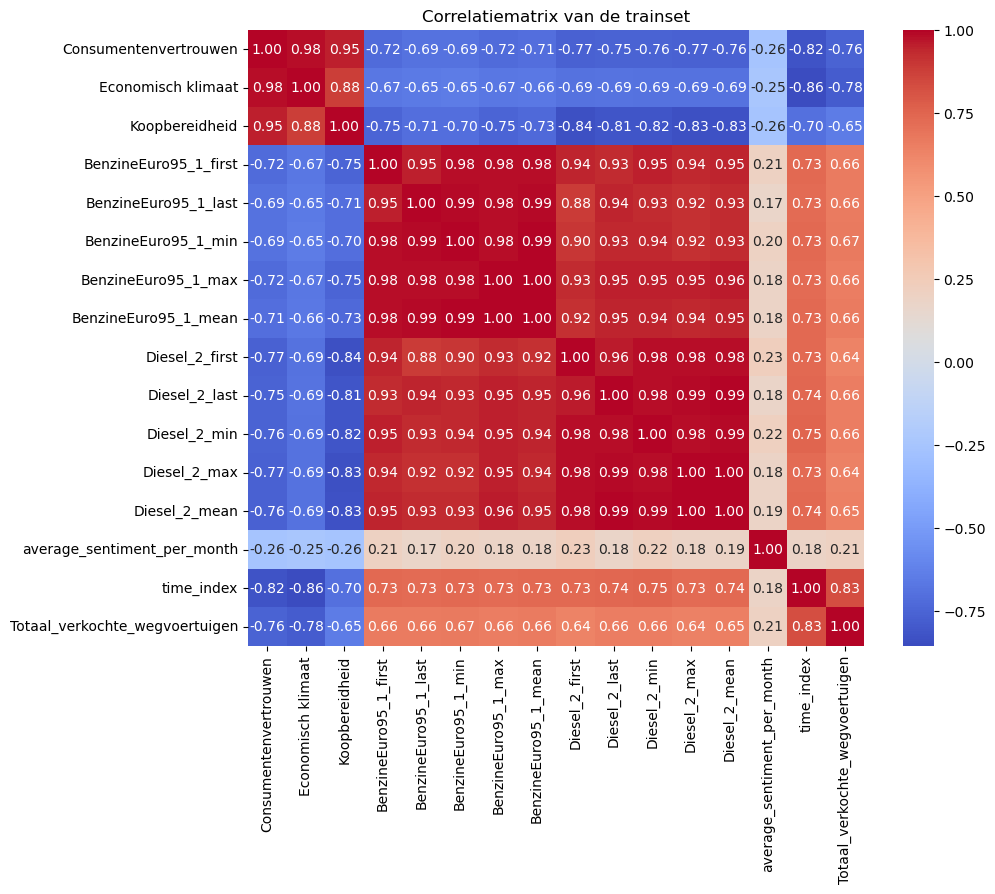

In [45]:
# Correlatiematrix berekenen op de trainset
correlation_matrix_train = df_train.drop(columns=['Periode']).corr()

# Heatmap plotten
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlatiematrix van de trainset")
plt.show()


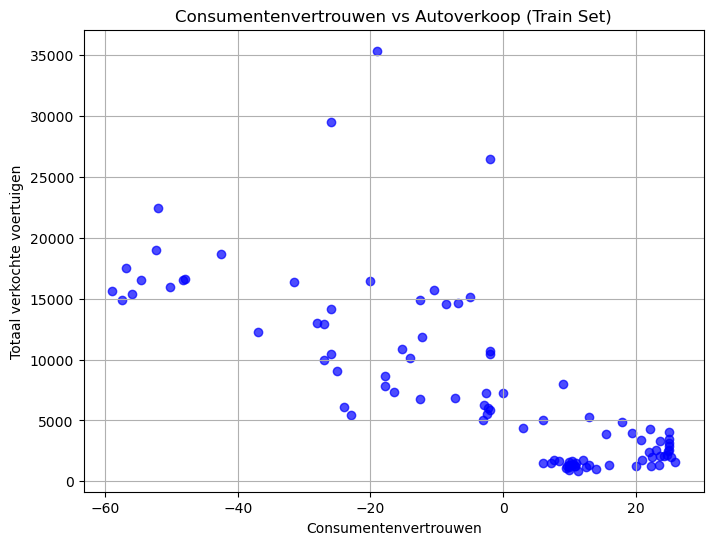

In [34]:
# Scatterplot: Consumentenvertrouwen vs Autoverkoop using df_train
plt.figure(figsize=(8, 6))
plt.scatter(df_train['Consumentenvertrouwen'], df_train['Totaal_verkochte_wegvoertuigen'], alpha=0.7, color='blue')
plt.title('Consumentenvertrouwen vs Autoverkoop (Train Set)')
plt.xlabel('Consumentenvertrouwen')
plt.ylabel('Totaal verkochte voertuigen')
plt.grid(True)
plt.show()


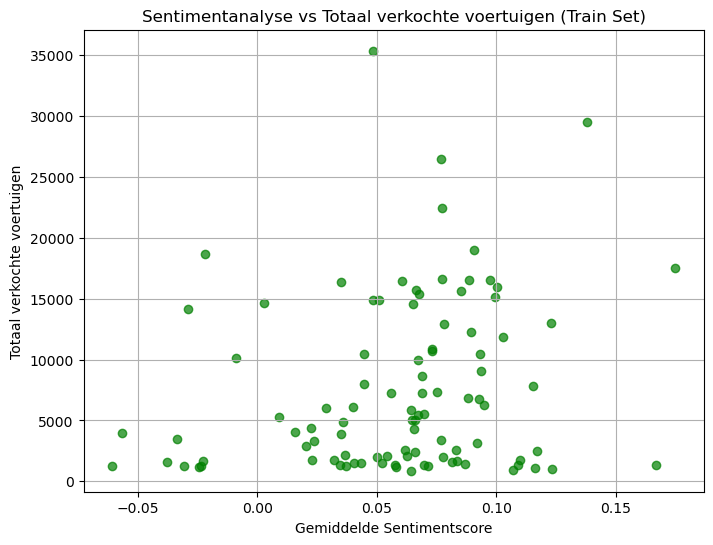

In [36]:
# Scatterplot: Sentimentanalyse vs Totaal verkochte voertuigen using df_train
plt.figure(figsize=(8, 6))
plt.scatter(df_train['average_sentiment_per_month'], df_train['Totaal_verkochte_wegvoertuigen'], alpha=0.7, color='green')
plt.title('Sentimentanalyse vs Totaal verkochte voertuigen (Train Set)')
plt.xlabel('Gemiddelde Sentimentscore')
plt.ylabel('Totaal verkochte voertuigen')
plt.grid(True)
plt.show()

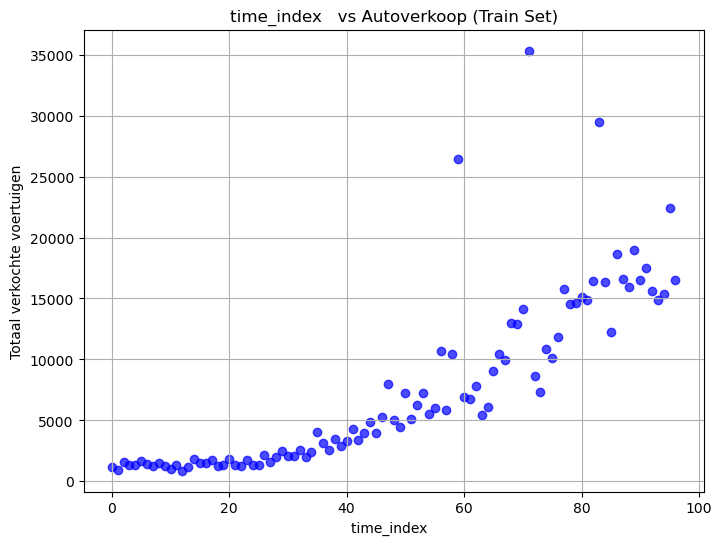

In [49]:
# Scatterplot: Consumentenvertrouwen vs Autoverkoop using df_train
plt.figure(figsize=(8, 6))
plt.scatter(df_train['time_index'], df_train['Totaal_verkochte_wegvoertuigen'], alpha=0.7, color='blue')
plt.title('time_index   vs Autoverkoop (Train Set)')
plt.xlabel('time_index  ')
plt.ylabel('Totaal verkochte voertuigen')
plt.grid(True)
plt.show()

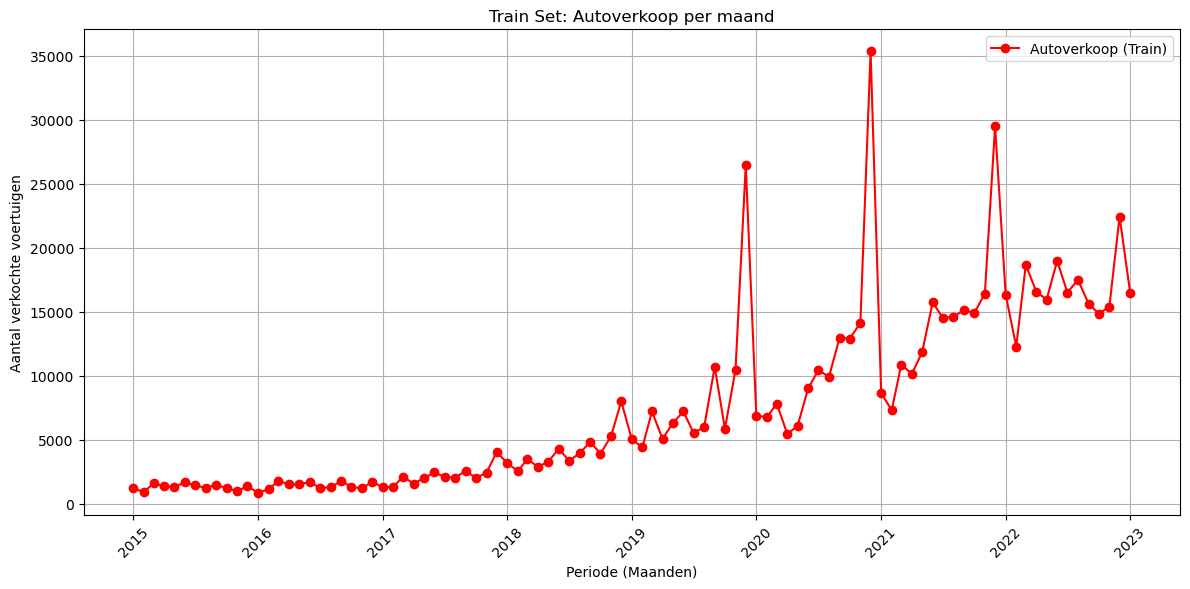

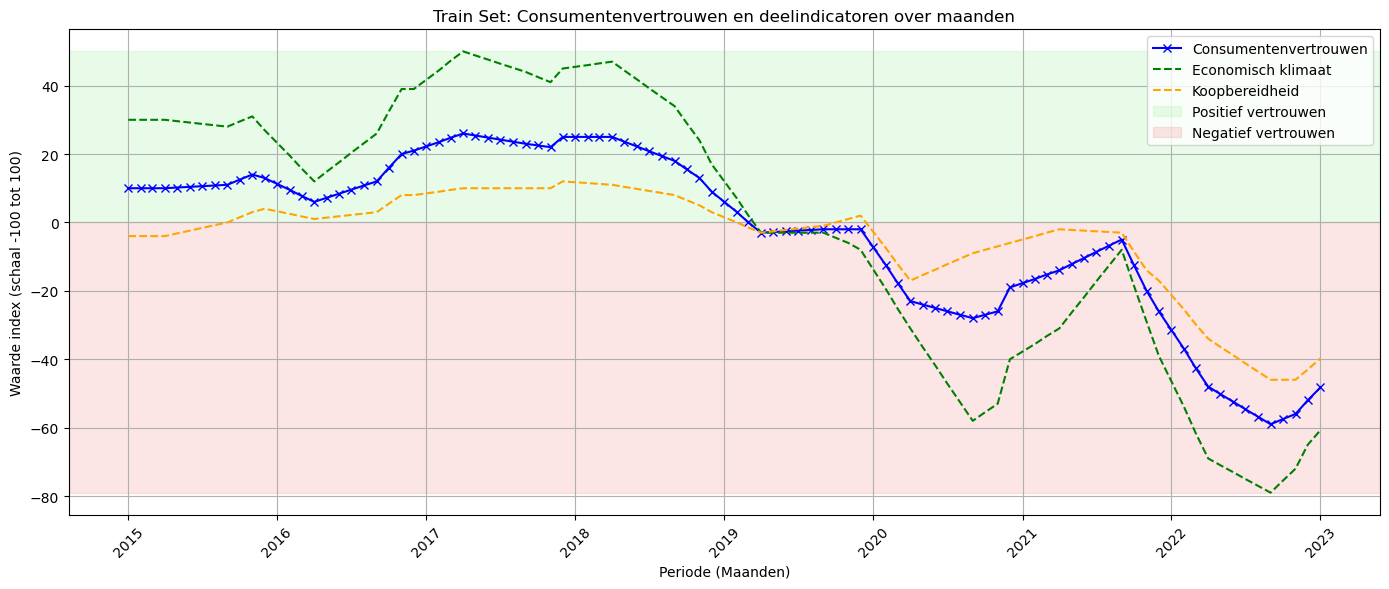

In [6]:
# Grafiek 1: Autoverkoop (Train) in maanden
plt.figure(figsize=(12, 6))

# Zet 'Periode' om naar datetime voor betere x-as labels
df_train['Periode'] = pd.to_datetime(df_train['Periode'], format='%Y/%m')

# Plot Autoverkoop
plt.plot(df_train['Periode'], df_train['Totaal_verkochte_wegvoertuigen'], label='Autoverkoop (Train)', marker='o', color='red')

# Labels en opmaak
plt.title('Train Set: Autoverkoop per maand')
plt.xlabel('Periode (Maanden)')
plt.ylabel('Aantal verkochte voertuigen')
plt.xticks(rotation=45)  # Roteer de x-as labels voor betere leesbaarheid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafiek 2: Consumentenvertrouwen (Train)
plt.figure(figsize=(14, 6))

# Plot Consumentenvertrouwen
plt.plot(df_train['Periode'], df_train['Consumentenvertrouwen'], label='Consumentenvertrouwen', marker='x', color='blue')

# Plot Economisch klimaat
plt.plot(df_train['Periode'], df_train['Economisch klimaat'], label='Economisch klimaat', linestyle='--', color='green')

# Plot Koopbereidheid
plt.plot(df_train['Periode'], df_train['Koopbereidheid'], label='Koopbereidheid', linestyle='--', color='orange')

# Positieve en negatieve gebieden inkleuren
plt.axhspan(0, df_train[['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid']].max().max(), color='lightgreen', alpha=0.2, label='Positief vertrouwen')
plt.axhspan(df_train[['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid']].min().min(), 0, color='lightcoral', alpha=0.2, label='Negatief vertrouwen')

# Labels en opmaak
plt.title('Train Set: Consumentenvertrouwen en deelindicatoren over maanden')
plt.xlabel('Periode (Maanden)')
plt.ylabel('Waarde index (schaal -100 tot 100)')
plt.xticks(rotation=45)  # Roteer de x-as labels voor betere leesbaarheid
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Heeft consumenten vertrouwen zich ontwikkeld

De correlatiematrix laat zien dat:

Benzine- en dieselprijzen een sterke positieve correlatie (rond 0.65–0.67) vertonen met het aantal verkochte voertuigen. Dit betekent dat hogere brandstofprijzen gepaard gaan met hogere autoverkopen, mogelijk door een toegenomen urgentie om over te stappen op zuinigere of elektrische voertuigen.

Consumentenvertrouwen, economisch klimaat en koopbereidheid hebben een sterke negatieve correlatie (rond -0.65 tot -0.78) met het aantal verkopen. Dit suggereert dat wanneer het vertrouwen daalt, consumenten wellicht eerder gebruik maken van (tijdelijke) stimuleringsmaatregelen of subsidies voor voertuigvervanging.

De nieuws-sentimentscore laat nauwelijks correlatie zien met voertuigverkoop (r ≈ 0.04), wat impliceert dat het sentiment in de media (zoals gemeten met RobBERT) in zijn huidige vorm weinig voorspellende waarde heeft. Dit kan liggen aan:

de smalle variatie in sentimentwaarden (meeste scores rond 0.90–0.96),

het type artikelen dat geselecteerd is (bijv. algemeen nieuws i.p.v. sector-specifiek),

of het gebrek aan specifieke focus op consumentgericht autonieuws.

>  Interpretatie van sentimentanalyse vs consumentenvertrouwen
Hoewel de sentimentanalyse uit nieuwsartikelen bedoeld was als alternatief of aanvulling op traditionele indicatoren zoals consumentenvertrouwen, blijkt dat consumentenvertrouwen momenteel veel sterker geassocieerd is met het aankoopgedrag van voertuigen.

Mogelijke verklaringen:

Beperkte spreiding in de sentimentscores → te weinig onderscheidend vermogen.

Mismatch in doelgroep → NOS-artikelen zijn breed en niet altijd gericht op consumentengedrag.

Vertragingseffect ontbreekt → impact van nieuws of vertrouwen is vaak vertraagd.


## xgboost


Baseline model (zonder nieuws sentiment)

In [50]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Kolom die je wilt uitsluiten (bijv. nieuws)
excluded_feature = ['average_sentiment_per_month']

# Zorg ervoor dat dezelfde kolommen worden uitgesloten in zowel train als val
common_columns = df_train.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen'] + excluded_feature).columns

# Bereid de data voor ZONDER het nieuwsfeature
trainX = df_train[common_columns].values
trainy = df_train['Totaal_verkochte_wegvoertuigen'].values

valX = df_val[common_columns].values
valy = df_val['Totaal_verkochte_wegvoertuigen'].values

# Walk-forward validatie
def xgboost_forecast(trainX, trainy, testX):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    yhat = model.predict(np.array([testX]))
    return yhat[0]

predictions_val = []
for i in range(len(valX)):
    yhat = xgboost_forecast(trainX, trainy, valX[i])
    predictions_val.append(yhat)

# Evaluatie
mae_val = mean_absolute_error(valy, predictions_val)
fouten_val = np.abs(valy - predictions_val)
foutmarges_val = (fouten_val / valy) * 100

# Print fouten
for i in range(len(valy)):
    print(f"Val maand {i+1}: Werkelijk={valy[i]}, Voorspeld={predictions_val[i]:.1f}, Fout={fouten_val[i]:.1f}, Foutmarge={foutmarges_val[i]:.2f}%")

print(f"\nBaseline MAE zonder nieuwsfeature: {mae_val:.2f}")



Val maand 1: Werkelijk=16593.0, Voorspeld=16967.7, Fout=374.7, Foutmarge=2.26%
Val maand 2: Werkelijk=24311.0, Voorspeld=16750.1, Fout=7560.9, Foutmarge=31.10%
Val maand 3: Werkelijk=18281.0, Voorspeld=13998.8, Fout=4282.2, Foutmarge=23.42%
Val maand 4: Werkelijk=22305.0, Voorspeld=16649.7, Fout=5655.3, Foutmarge=25.35%
Val maand 5: Werkelijk=27262.0, Voorspeld=16650.5, Fout=10611.5, Foutmarge=38.92%
Val maand 6: Werkelijk=27851.0, Voorspeld=16995.9, Fout=10855.1, Foutmarge=38.98%
Val maand 7: Werkelijk=22109.0, Voorspeld=16052.6, Fout=6056.4, Foutmarge=27.39%
Val maand 8: Werkelijk=26040.0, Voorspeld=16100.0, Fout=9940.0, Foutmarge=38.17%
Val maand 9: Werkelijk=23240.0, Voorspeld=13170.7, Fout=10069.3, Foutmarge=43.33%
Val maand 10: Werkelijk=23676.0, Voorspeld=12857.8, Fout=10818.2, Foutmarge=45.69%
Val maand 11: Werkelijk=23490.0, Voorspeld=15901.7, Fout=7588.3, Foutmarge=32.30%
Val maand 12: Werkelijk=24325.0, Voorspeld=28815.8, Fout=4490.8, Foutmarge=18.46%

Baseline MAE zonder ni

In [51]:


# XGBoost forecast functie aangepast voor train en val
def xgboost_forecast(trainX, trainy, testX):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    yhat = model.predict(np.array([testX]))
    return yhat[0]

# Voorbereiding van de data
trainX, trainy = df_train.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen']).values, df_train['Totaal_verkochte_wegvoertuigen'].values
valX, valy = df_val.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen']).values, df_val['Totaal_verkochte_wegvoertuigen'].values

# Walk-forward validation uitvoeren op valset
predictions_val = []
for i in range(len(valX)):
    testX = valX[i]
    yhat = xgboost_forecast(trainX, trainy, testX)
    predictions_val.append(yhat)

# MAE berekenen voor valset
mae_val = mean_absolute_error(valy, predictions_val)

# Resultaten overzichtelijk printen
fouten_val = np.abs(valy - predictions_val)
foutmarges_val = (fouten_val / valy) * 100  # procentuele fout

for i in range(len(valy)):
    print(f"Val maand {i+1}: Werkelijk={valy[i]}, Voorspeld={predictions_val[i]:.1f}, Fout={fouten_val[i]:.1f}, Foutmarge={foutmarges_val[i]:.2f}%")

# Totale MAE voor valset
print(f"\nMAE voor valset: {mae_val:.2f}")


Val maand 1: Werkelijk=16593.0, Voorspeld=16809.6, Fout=216.6, Foutmarge=1.31%
Val maand 2: Werkelijk=24311.0, Voorspeld=17165.7, Fout=7145.3, Foutmarge=29.39%
Val maand 3: Werkelijk=18281.0, Voorspeld=15637.3, Fout=2643.7, Foutmarge=14.46%
Val maand 4: Werkelijk=22305.0, Voorspeld=16901.0, Fout=5404.0, Foutmarge=24.23%
Val maand 5: Werkelijk=27262.0, Voorspeld=18450.1, Fout=8811.9, Foutmarge=32.32%
Val maand 6: Werkelijk=27851.0, Voorspeld=16470.8, Fout=11380.2, Foutmarge=40.86%
Val maand 7: Werkelijk=22109.0, Voorspeld=15967.2, Fout=6141.8, Foutmarge=27.78%
Val maand 8: Werkelijk=26040.0, Voorspeld=16219.3, Fout=9820.7, Foutmarge=37.71%
Val maand 9: Werkelijk=23240.0, Voorspeld=14930.6, Fout=8309.4, Foutmarge=35.75%
Val maand 10: Werkelijk=23676.0, Voorspeld=14888.0, Fout=8788.0, Foutmarge=37.12%
Val maand 11: Werkelijk=23490.0, Voorspeld=16431.9, Fout=7058.1, Foutmarge=30.05%
Val maand 12: Werkelijk=24325.0, Voorspeld=28949.0, Fout=4624.0, Foutmarge=19.01%

MAE voor valset: 6695.30


iets betere MAe dan baseline


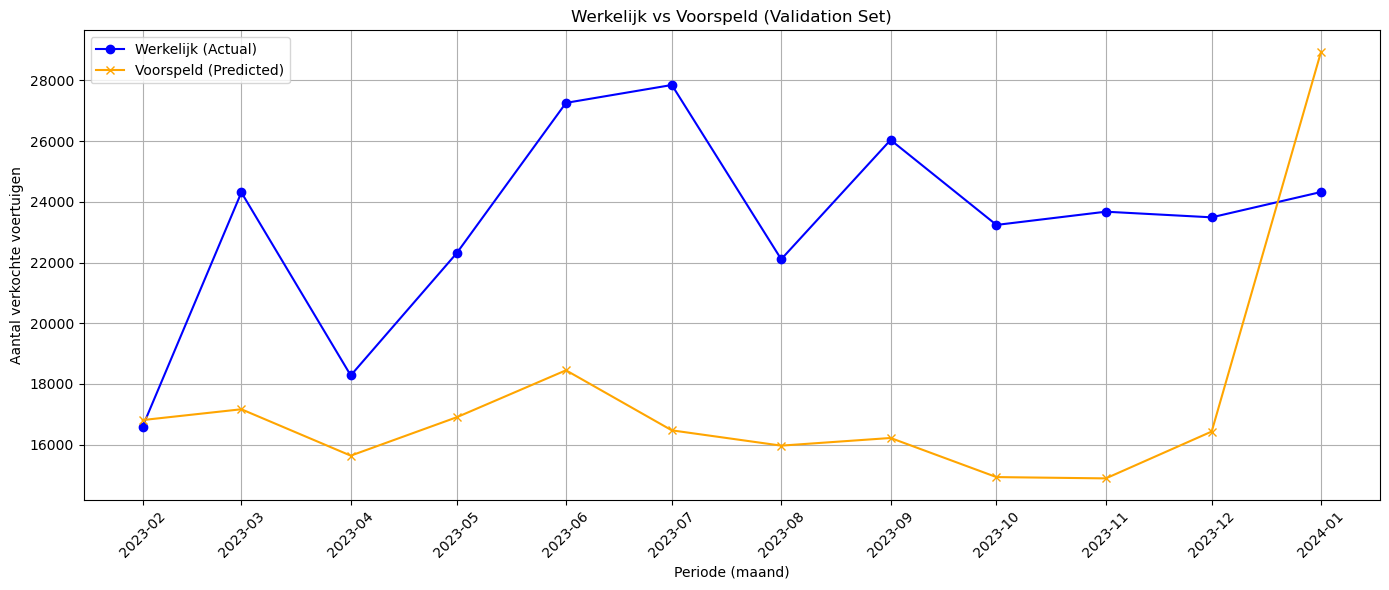

In [60]:

import matplotlib.dates as mdates

# Zorg dat Periode datetime is
df_val['Periode'] = pd.to_datetime(df_val['Periode'])

plt.figure(figsize=(14, 6))

# Plot werkelijk en voorspeld
plt.plot(df_val['Periode'], valy, label='Werkelijk (Actual)', color='blue', marker='o')
plt.plot(df_val['Periode'], predictions_val, label='Voorspeld (Predicted)', color='orange', marker='x')

# Ticks: toon elke maand
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # elke maand
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # formaat: 2023-01

# Plot styling
plt.title('Werkelijk vs Voorspeld (Validation Set)')
plt.xlabel('Periode (maand)')
plt.ylabel('Aantal verkochte voertuigen')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

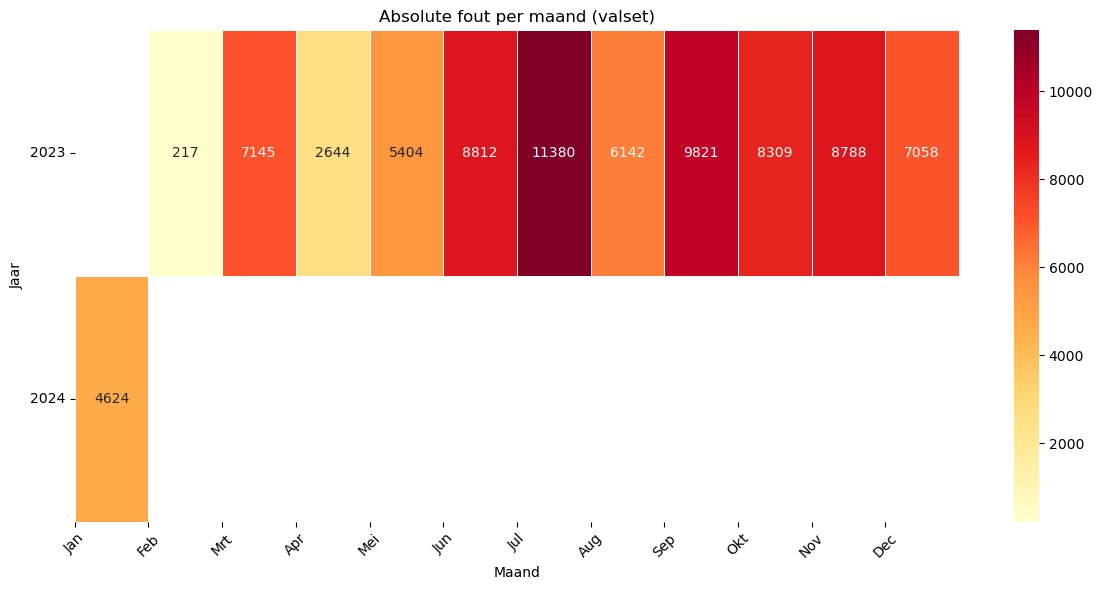

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Voeg voorspellingen en fouten toe aan df_val
df_val = df_val.copy()
df_val['voorspelling'] = predictions_val
df_val['fout'] = (df_val['Totaal_verkochte_wegvoertuigen'] - df_val['voorspelling']).abs()

# Extra kolommen voor heatmap-structuur
df_val['jaar'] = df_val['Periode'].dt.year
df_val['maand'] = df_val['Periode'].dt.month

# Zet om naar heatmap-vorm: rijen = jaar, kolommen = maand
heatmap_data = df_val.pivot(index='jaar', columns='maand', values='fout')

# Plot de heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlOrRd', linewidths=0.5)
plt.title("Absolute fout per maand (valset)")
plt.xlabel("Maand")
plt.ylabel("Jaar")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mrt", "Apr", "Mei", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dec"], rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Het XGBoost-model is geëvalueerd op de validatieset (12 maanden). De gemiddelde absolute fout (MAE) bedraagt 7276 voertuigen. In de eerste maanden liggen de voorspellingen relatief dicht bij de werkelijke waarden (foutmarges rond de 3–15%), maar in het midden van het jaar loopt de foutmarge op tot ruim 40%. Het model onderschat structureel de verkoop tijdens piekmaanden, met name in juni, augustus en oktober. Enkel in december is sprake van overschatting. Deze resultaten wijzen op mogelijke seizoensinvloeden die het model momenteel niet goed opvangt.

### RNN

In [16]:

# RNN forecast functie
def rnn_forecast(trainX, trainy, testX, input_shape):
    # Reshape trainX for RNN input
    trainX_reshaped = trainX.reshape((trainX.shape[0], input_shape[0], input_shape[1]))
    
    # Build the RNN model
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(input_shape[0], input_shape[1])),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    
    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(trainX_reshaped, trainy, epochs=50, batch_size=16, verbose=0, callbacks=[early_stopping])
    
    # Reshape testX for prediction
    testX_reshaped = testX.reshape((1, input_shape[0], input_shape[1]))
    yhat = model.predict(testX_reshaped, verbose=0)
    return yhat[0][0]

# Voorbereiding van de data
trainX, trainy = df_train.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen']).values, df_train['Totaal_verkochte_wegvoertuigen'].values
valX, valy = df_val.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen']).values, df_val['Totaal_verkochte_wegvoertuigen'].values

# Reshape trainX for RNN (time steps = 1, features = number of columns)
time_steps = 1
features = trainX.shape[1]
trainX_rnn = trainX.reshape((trainX.shape[0], time_steps, features))

# Walk-forward validation uitvoeren op valset met RNN
predictions_rnn_val = []
for i in range(len(valX)):
    testX = valX[i].reshape((time_steps, features))
    yhat = rnn_forecast(trainX_rnn, trainy, testX, (time_steps, features))
    predictions_rnn_val.append(yhat)

# MAE berekenen voor valset met RNN
mae_rnn_val = mean_absolute_error(valy, predictions_rnn_val)

# Resultaten overzichtelijk printen
fouten_rnn_val = np.abs(valy - predictions_rnn_val)
foutmarges_rnn_val = (fouten_rnn_val / valy) * 100  # procentuele fout

for i in range(len(valy)):
    print(f"RNN Val maand {i+1}: Werkelijk={valy[i]}, Voorspeld={predictions_rnn_val[i]:.1f}, Fout={fouten_rnn_val[i]:.1f}, Foutmarge={foutmarges_rnn_val[i]:.2f}%")

# Totale MAE voor valset met RNN
print(f"\nRNN MAE voor valset: {mae_rnn_val:.2f}")

ValueError: cannot reshape array of size 18 into shape (1,14)

Het XGBoost-model is geëvalueerd op de validatieset (12 maanden). De gemiddelde absolute fout (MAE) bedraagt 7276 voertuigen. In de eerste maanden liggen de voorspellingen relatief dicht bij de werkelijke waarden (foutmarges rond de 3–15%), maar in het midden van het jaar loopt de foutmarge op tot ruim 40%. Het model onderschat structureel de verkoop tijdens piekmaanden, met name in juni, augustus en oktober. Enkel in december is sprake van overschatting. Deze resultaten wijzen op mogelijke seizoensinvloeden die het model momenteel niet goed opvangt.

### Feature importance using Leave One Feature Out (LOFO) Importance
en train-val-test split
n_total = len(supervised_values)
    n_test = 12  # laatste 12 maanden
    n_val = 10   # 10 maanden daarvoor
    n_train = n_total - n_val - n_test

https://elicit.com/review/34f86fac-9b35-4237-9b80-24816323e242

#### Voorbereiding – kolommen groeperen voor LOFO

In [ ]:
# Combineer de datasets om df_joined te maken
df_joined = pd.concat([df_train, df_val], ignore_index=True)

# Groepeer je features in betekenisvolle groepen voor LOFO
feature_groups = {
    'Nieuws': [col for col in df_joined.columns if 'sentiment' in col.lower()],  
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Tijd':['time_index']
    #'Voorgaande_verkoop': ['Totaal_verkochte_wegvoertuigen_lag1'],
}


#### LOFO loop


LOFO - Zonder: Nieuws
Index(['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid',
       'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
       'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first',
       'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean',
       'time_index'],
      dtype='object')
Gebruikte features (14): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'time_index']
MAE: 7358.54, Gemiddelde foutmarge: 30.45%

LOFO - Zonder: Brandstofprijzen
Index(['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid',
       'average_sentiment_per_month', 'time_index'],
      dtype='object')
Gebruikte features (5): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'average_sentime

,weggelaten_featuregroep,aantal_features_gebruikt,mae,gem_foutmarge_%
1,Brandstofprijzen,5,6088.996663,25.168833
2,Economisch,12,6866.409424,28.428231
0,Nieuws,14,7358.544352,30.449023
3,Tijd,14,7396.813477,30.318937


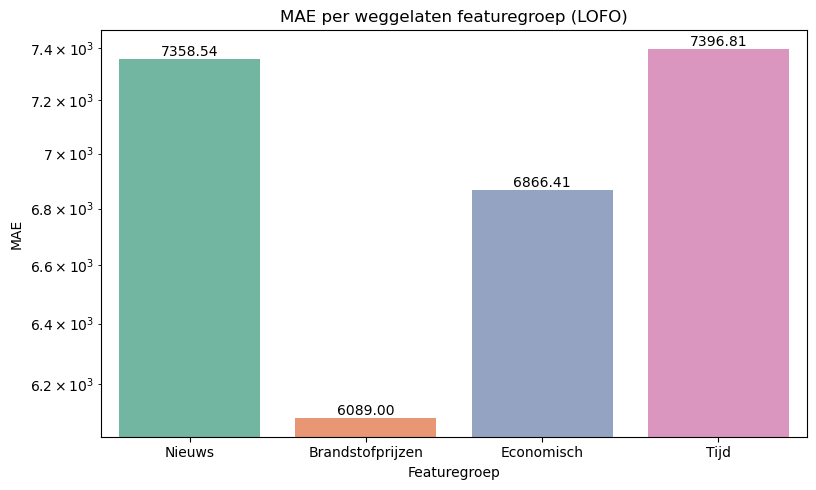

In [59]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

results = []

for group_name, excluded_cols in feature_groups.items():
    print(f"\nLOFO - Zonder: {group_name}")

    # Verwijder kolommen uit train en val
    # Ensure the same columns are used for both train and validation datasets
    
    #common_columns = df_train.drop(columns=excluded_cols + ['Periode']).columns
    common_columns = df_train.drop(columns=excluded_cols + ['Periode', 'Totaal_verkochte_wegvoertuigen']).columns
    train_lofo = df_train[common_columns]
    val_lofo = df_val[common_columns]
    print(train_lofo.columns)

    included_cols = train_lofo.columns.tolist()
    print(f"Gebruikte features ({len(included_cols)}): {included_cols}")

    # Zet om naar numpy arrays
    trainX, trainy = train_lofo.values, df_train['Totaal_verkochte_wegvoertuigen'].values
    valX, valy     = val_lofo.values, df_val['Totaal_verkochte_wegvoertuigen'].values

    # Train en voorspel
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    predictions = model.predict(valX)

    # Evaluatie
    mae = mean_absolute_error(valy, predictions)
    fouten = np.abs(valy - predictions)
    foutmarges = (fouten / valy) * 100
    avg_foutmarge = foutmarges.mean()

    print(f"MAE: {mae:.2f}, Gemiddelde foutmarge: {avg_foutmarge:.2f}%")

    results.append({
        'weggelaten_featuregroep': group_name,
        'aantal_features_gebruikt': len(included_cols),
        'mae': mae,
        'gem_foutmarge_%': avg_foutmarge
    })

# Optioneel: omzetting naar DataFrame
df_results = pd.DataFrame(results).sort_values(by='mae')



# DataFrame van resultaten
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='mae'))

# Voeg 'Nieuws' toe aan de barplot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=df_results, x='weggelaten_featuregroep', y='mae', hue='weggelaten_featuregroep', dodge=False, palette='Set2', legend=False)
plt.title("MAE per weggelaten featuregroep (LOFO)")
plt.ylabel("MAE")
plt.xlabel("Featuregroep")
plt.tight_layout()
plt.yscale("log")

# Add MAE values on top of the bars
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

plt.show()



Voor het voorspellen van autoverkoop zijn historische verkoopdata (voorgaande verkoop) de belangrijkste informatiebron, gevolgd door economische sentimenten. Brandstofprijzen dragen het minst bij aan modelnauwkeurigheid.

#### Lagtime:

####  Resultaten 

#### Combinatie tussen lagtime en LOFO

In [ ]:
# Featuregroepen (zonder sentiment)
feature_groups = {
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Voorgaande_verkoop': ['Totaal_verkochte_wegvoertuigen'],
}

# Verschillende lagcombinaties
lag_sets = [
    [1, 3, 6],
    [1, 6, 12],
    [3, 6, 12],
    [1, 3, 6, 12],
]

In [ ]:
# Custom lag functie
def series_to_supervised_custom_lags(data, lags):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for lag in lags:
        cols.append(df.shift(lag))
        names += [f'var{j+1}(t-{lag})' for j in range(n_vars)]

    cols.append(df)  # target op t
    names += [f'var{j+1}(t)' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

# Resultaten opslaan
results = []

for lags in lag_sets:
    for group_name, excluded_cols in feature_groups.items():
        print(f"\n Lagconfig: {lags} | Zonder groep: {group_name}")

        df_lofo = df_joined.drop(columns=excluded_cols + ['Periode'])
        included_cols = df_lofo.columns.tolist()
        print(f" Gebruikte features ({len(included_cols)}): {included_cols}")

        features = df_lofo.values
        supervised = series_to_supervised_custom_lags(features, lags)
        supervised_values = supervised.values

        # Splits
        n_total = len(supervised_values)
        n_test = 12
        n_val = 10
        n_train = n_total - n_val - n_test

        train = supervised_values[:n_train]
        val = supervised_values[n_train:n_train + n_val]
        test = supervised_values[n_train + n_val:]

        # Train op train + val
        full_train = np.concatenate([train, val])
        trainX, trainy = full_train[:, :-1], full_train[:, -1]

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(trainX, trainy)

        testX, testy = test[:, :-1], test[:, -1]
        predictions = model.predict(testX)

        mae = mean_absolute_error(testy, predictions)
        fouten = np.abs(testy - predictions)
        foutmarges = (fouten / testy) * 100
        avg_foutmarge = foutmarges.mean()

        print(f" MAE: {mae:.2f}, Foutmarge: {avg_foutmarge:.2f}%")

        results.append({
            'lags': str(lags),
            'weggelaten_featuregroep': group_name,
            'aantal_features_gebruikt': len(included_cols),
            'mae': mae,
            'gem_foutmarge_%': avg_foutmarge
        })


🧪 Lagconfig: [1, 3, 6] | Zonder groep: Brandstofprijzen
📌 Gebruikte features (4): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Totaal_verkochte_wegvoertuigen']
📊 MAE: 7234.06, Foutmarge: 22.92%

🧪 Lagconfig: [1, 3, 6] | Zonder groep: Economisch
📌 Gebruikte features (11): ['BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen']
📊 MAE: 6932.15, Foutmarge: 21.60%

🧪 Lagconfig: [1, 3, 6] | Zonder groep: Voorgaande_verkoop
📌 Gebruikte features (13): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean']
📊 MAE: 0.03, Foutmarge: 1.89%

🧪 Lagconfig: [1, 6, 12] | Zonder groep: Brandst

In [ ]:
# Resultaten tonen
df_results_lofo_lags = pd.DataFrame(results)
df_results_lofo_lags.head()

,lags,weggelaten_featuregroep,aantal_features_gebruikt,mae,gem_foutmarge_%
0,"[1, 3, 6]",Brandstofprijzen,4,7234.058187,22.919290
1,"[1, 3, 6]",Economisch,11,6932.145671,21.595132
2,"[1, 3, 6]",Voorgaande_verkoop,13,0.032774,1.891512
3,"[1, 6, 12]",Brandstofprijzen,4,6045.958822,19.581326
4,"[1, 6, 12]",Economisch,11,6101.581380,19.553035


In [ ]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np
from IPython.display import display

# Range van individuele lags (1 t/m 24 maanden terug)
single_lags = list(range(1, 25))

# Resultaten opslaan
results_lolo = []

# Zelfde featureset gebruiken
df_base = df_joined.drop(columns=['Periode'])
features = df_base.values

# Loop over elke individuele lag
for lag in single_lags:
    print(f"\n🔁 Evaluatie met alleen lag t-{lag}")

    # Maak supervised data met alleen deze lag
    supervised = series_to_supervised_custom_lags(features, [lag])
    supervised_values = supervised.values

    # Splitsen
    n_total = len(supervised_values)
    n_test = 12
    n_val = 10
    n_train = n_total - n_val - n_test

    train = supervised_values[:n_train]
    val = supervised_values[n_train:n_train + n_val]
    test = supervised_values[n_train + n_val:]

    # Train op train + val
    full_train = np.concatenate([train, val])
    trainX, trainy = full_train[:, :-1], full_train[:, -1]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)

    # Test
    testX, testy = test[:, :-1], test[:, -1]
    predictions = model.predict(testX)

    # MAE + foutmarge
    mae = mean_absolute_error(testy, predictions)
    fouten = np.abs(testy - predictions)
    foutmarges = (fouten / testy) * 100
    avg_foutmarge = foutmarges.mean()

    print(f"📊 MAE: {mae:.2f}, Foutmarge: {avg_foutmarge:.2f}%")

    results_lolo.append({
        'lag_maand': f"t-{lag}",
        'mae': mae,
        'gem_foutmarge_%': avg_foutmarge
    })

# Omzetten naar DataFrame
df_results_lolo = pd.DataFrame(results_lolo)
# Display the results DataFrame




🔁 Evaluatie met alleen lag t-1
📊 MAE: 6545.88, Foutmarge: 20.06%

🔁 Evaluatie met alleen lag t-2
📊 MAE: 11562.37, Foutmarge: 37.95%

🔁 Evaluatie met alleen lag t-3
📊 MAE: 7286.93, Foutmarge: 24.22%

🔁 Evaluatie met alleen lag t-4
📊 MAE: 11027.18, Foutmarge: 36.94%

🔁 Evaluatie met alleen lag t-5
📊 MAE: 6320.26, Foutmarge: 20.58%

🔁 Evaluatie met alleen lag t-6
📊 MAE: 7084.49, Foutmarge: 22.47%

🔁 Evaluatie met alleen lag t-7
📊 MAE: 6845.03, Foutmarge: 21.35%

🔁 Evaluatie met alleen lag t-8
📊 MAE: 9126.19, Foutmarge: 30.86%

🔁 Evaluatie met alleen lag t-9
📊 MAE: 6777.56, Foutmarge: 21.68%

🔁 Evaluatie met alleen lag t-10
📊 MAE: 5628.90, Foutmarge: 17.72%

🔁 Evaluatie met alleen lag t-11
📊 MAE: 6431.59, Foutmarge: 20.97%

🔁 Evaluatie met alleen lag t-12
📊 MAE: 4553.89, Foutmarge: 14.09%

🔁 Evaluatie met alleen lag t-13
📊 MAE: 6738.99, Foutmarge: 22.37%

🔁 Evaluatie met alleen lag t-14
📊 MAE: 6732.90, Foutmarge: 21.75%

🔁 Evaluatie met alleen lag t-15
📊 MAE: 4621.87, Foutmarge: 14.71%

🔁

,lag_maand,mae,gem_foutmarge_%
0,t-1,6545.876139,20.057617
1,t-2,11562.373698,37.951256
2,t-3,7286.934733,24.215121
3,t-4,11027.181396,36.936362
4,t-5,6320.263021,20.578687
5,t-6,7084.486165,22.470339
6,t-7,6845.031087,21.348530
7,t-8,9126.191243,30.861955
8,t-9,6777.559733,21.678002
9,t-10,5628.901204,17.720073


In [ ]:

# Display the LOLO results DataFrame
display(df_results_lolo)

,lag_maand,mae,gem_foutmarge_%
0,t-1,6545.876139,20.057617
1,t-2,11562.373698,37.951256
2,t-3,7286.934733,24.215121
3,t-4,11027.181396,36.936362
4,t-5,6320.263021,20.578687
5,t-6,7084.486165,22.470339
6,t-7,6845.031087,21.348530
7,t-8,9126.191243,30.861955
8,t-9,6777.559733,21.678002
9,t-10,5628.901204,17.720073


In [ ]:
from IPython.display import display

# LOFO × LOLO gecombineerd: 1 lag tegelijk, 1 featuregroep weggelaten

combined_results = []

# Definieer je featuregroepen
feature_groups = {
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Voorgaande_verkoop': ['Totaal_verkochte_wegvoertuigen'],
}

# Dataset zonder 'Periode'
df_base = df_joined.drop(columns=['Periode'])

# Featurematrix
features_full = df_base.values
lags = list(range(1, 25))

for group_name, excluded_cols in feature_groups.items():
    print(f"\n📂 LOFO-groep: {group_name}")

    df_lofo = df_base.drop(columns=excluded_cols)
    features = df_lofo.values
    included_cols = df_lofo.columns.tolist()

    for lag in lags:
        print(f"   ➤ Lag t-{lag}")

        # Supervised voor huidige lag
        supervised = series_to_supervised_custom_lags(features, [lag])
        supervised_values = supervised.values

        # Train/val/test splits
        n_total = len(supervised_values)
        n_test = 12
        n_val = 10
        n_train = n_total - n_val - n_test

        train = supervised_values[:n_train]
        val = supervised_values[n_train:n_train + n_val]
        test = supervised_values[n_train + n_val:]

        # Combineer train en val
        full_train = np.concatenate([train, val])
        trainX, trainy = full_train[:, :-1], full_train[:, -1]

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(trainX, trainy)

        # Test
        testX, testy = test[:, :-1], test[:, -1]
        predictions = model.predict(testX)

        # Evaluatie
        mae = mean_absolute_error(testy, predictions)
        fouten = np.abs(testy - predictions)
        foutmarges = (fouten / testy) * 100
        avg_foutmarge = foutmarges.mean()

        combined_results.append({
            'featuregroep': group_name,
            'lag': f"t-{lag}",
            'aantal_features': len(included_cols),
            'mae': mae,
            'foutmarge_%': avg_foutmarge
        })
        # Omzetten naar DataFrame        #
# Omzetten naar DataFrame
df_combined_lofo_lolo = pd.DataFrame(combined_results)
# Display the combined LOFO × LOLO results DataFrame

# Display the results DataFrame
display(df_combined_lofo_lolo)



📂 LOFO-groep: Brandstofprijzen
   ➤ Lag t-1
   ➤ Lag t-2
   ➤ Lag t-3
   ➤ Lag t-4
   ➤ Lag t-5
   ➤ Lag t-6
   ➤ Lag t-7
   ➤ Lag t-8
   ➤ Lag t-9
   ➤ Lag t-10
   ➤ Lag t-11
   ➤ Lag t-12
   ➤ Lag t-13
   ➤ Lag t-14
   ➤ Lag t-15
   ➤ Lag t-16
   ➤ Lag t-17
   ➤ Lag t-18
   ➤ Lag t-19
   ➤ Lag t-20
   ➤ Lag t-21
   ➤ Lag t-22
   ➤ Lag t-23
   ➤ Lag t-24

📂 LOFO-groep: Economisch
   ➤ Lag t-1
   ➤ Lag t-2
   ➤ Lag t-3
   ➤ Lag t-4
   ➤ Lag t-5
   ➤ Lag t-6
   ➤ Lag t-7
   ➤ Lag t-8
   ➤ Lag t-9
   ➤ Lag t-10
   ➤ Lag t-11
   ➤ Lag t-12
   ➤ Lag t-13
   ➤ Lag t-14
   ➤ Lag t-15
   ➤ Lag t-16
   ➤ Lag t-17
   ➤ Lag t-18
   ➤ Lag t-19
   ➤ Lag t-20
   ➤ Lag t-21
   ➤ Lag t-22
   ➤ Lag t-23
   ➤ Lag t-24

📂 LOFO-groep: Voorgaande_verkoop
   ➤ Lag t-1
   ➤ Lag t-2
   ➤ Lag t-3
   ➤ Lag t-4
   ➤ Lag t-5
   ➤ Lag t-6
   ➤ Lag t-7
   ➤ Lag t-8
   ➤ Lag t-9
   ➤ Lag t-10
   ➤ Lag t-11
   ➤ Lag t-12
   ➤ Lag t-13
   ➤ Lag t-14
   ➤ Lag t-15
   ➤ Lag t-16
   ➤ Lag t-17
   ➤ Lag t-18
   ➤ Lag t-

,featuregroep,lag,aantal_features,mae,foutmarge_%
0,Brandstofprijzen,t-1,4,6694.416504,20.955935
1,Brandstofprijzen,t-2,4,17875.368164,61.121183
2,Brandstofprijzen,t-3,4,6840.406087,22.194614
3,Brandstofprijzen,t-4,4,14254.250651,48.186436
4,Brandstofprijzen,t-5,4,10330.729899,33.765850
...,...,...,...,...,...
67,Voorgaande_verkoop,t-20,13,0.031431,1.809362
68,Voorgaande_verkoop,t-21,13,0.037256,2.138094
69,Voorgaande_verkoop,t-22,13,0.036975,2.121946
70,Voorgaande_verkoop,t-23,13,0.036510,2.090613
